# Selfie-VAE

In [1]:
import torch
import pandas as pd
import selfies as sf

In [8]:
# !open ./cloned_repos/VAE-tr/ligands.csv

In [3]:
df_smiles = pd.read_csv("./cloned_repos/VAE-tr/ligands.csv",index_col=0)
df_smiles["selfies"] = df_smiles["smiles"].apply(sf.encoder)
# df_smiles = pd.read_csv("./cloned_repos/qcbm/example/data/tiny.csv",index_col=0)
df_smiles

,smiles,selfies
0,CC1=C(CNc2cccnc2C)CN(C)C1OCCCCCN,[C][C][=C][Branch1][N][C][N][C][=C][C][=C][N][...
1,CCN1CCCC1Cc1nc2c(c(N(C)CCCNC)n1)CCN(c1cncc3ccc...,[C][C][N][C][C][C][C][Ring1][Branch1][C][C][=N...
2,C1=CCC(CCOc2nc3c([nH]2)CCN(c2ccccc2)C3)CC1,[C][=C][C][C][Branch2][Ring1][=N][C][C][O][C][...
3,C=CC1(Oc2nc(N3CCN(CC)CC3)c3cnc(-c4ccccc4NC)c(F...,[C][=C][C][Branch2][Ring2][=C][O][C][=N][C][Br...
4,C=CNC(C)CCOc1nc(CN2CCNCC2)c2cnc(-c3ccccc3C(F)(...,[C][=C][N][C][Branch1][C][C][C][C][O][C][=N][C...
...,...,...
996,CCCC1CN(c2nc(OCC3CCCN3C)ncc2CC=Cc2cccc(Cl)c2)CCN1,[C][C][C][C][C][N][Branch2][Ring2][Ring1][C][=...
997,CCN(Cc1ccnc(CC2CCCN2C)n1)C(C=Cc1[nH]ncc1O)CN,[C][C][N][Branch2][Ring1][Branch1][C][C][=C][C...
998,CN1CCCC1CC1=NC(CCNO)C(N2CCN(C)C(CCc3nccc4cccc(...,[C][N][C][C][C][C][Ring1][Branch1][C][C][=N][C...
999,CCCCN(C)Oc1nc2c(c(N3CCNC(CC)C3)n1)CCN(c1nccc3c...,[C][C][C][C][N][Branch1][C][C][O][C][=N][C][=C...


In [4]:
import sys
sys.path.append("./cloned_repos/generative-models")
from qumedl.mol.encoding.selfies_ import Selfies


selfies = Selfies(
    df_smiles["selfies"],
    start_token="[^]",
    pad_token="[nop]",
#     max_length = 340
)
dataset = selfies.as_dataset(include_start_token=False)

# decode selfies to smiles
# selfies.decode(dataset[:5][0])
# encode smiles to selfies
# selfies.encode(df_smiles["selfies"][:5])[0]

In [5]:
dataset[0][0].shape

torch.Size([346])

In [6]:
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

input_dim = selfies._max_length # 346 
hidden_dim = 70 
latent_dim = 16
epochs = 100
# epochs = 10
learning_rate = 3e-3
batch_size = 16

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim,latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h = self.linear(x)
#         h = F.relu(h)
        h = F.sigmoid(h)       
        h = self.dropout(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5*logvar)
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim,output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(output_dim)
        self.normalize = torch.nn.BatchNorm1d(output_dim)
    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.relu(h)
#         h = self.softmax(h)
        # Normal 
#         h = self.normalize(h)
        return h
#         x_hat = F.sigmoid(h)
#         return x_hat
    
def reparametrize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps*sigma
    return z

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def get_loss(self, x, print_=False):
        mu, sigma = self.encoder(x)
        z = reparametrize(mu, sigma)
        x_hat = self.decoder(z)
        batch_size = len(x)
#         L1 = F.binary_cross_entropy_with_logits(x_hat, x, reduction="sum")
        L1 = F.mse_loss(x_hat, x, reduction="sum")
        L2 = - torch.sum(1 + torch.log(sigma**2) -mu**2 - sigma**2)
        if print_:
            print("z",z)
            print("x", x)
            print("x_hat",x_hat)
            print("L1",L1/batch_size)
            print("L2",L2/batch_size)
        return (L1+L2) / batch_size

In [7]:
torch.manual_seed(0)

dataloader = torch.utils.data.DataLoader(
    dataset[:][0].to(torch.float32),
    batch_size=batch_size,
    shuffle=True,
)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    
    for x in dataloader:
        optimizer.zero_grad()
        loss= model.get_loss(x)
        loss.backward()        
        optimizer.step()
        loss_sum += loss.item()
#     model.get_loss(x,print_=True)  
    loss_avg = loss_sum/len(dataloader)
    losses.append(loss_avg)
    print(epoch, loss_avg)

0 11912.097036210318
1 6126.777328249008
2 6031.395779079861
3 6036.476438492064
4 5992.9296875
5 5997.923595610119
6 5935.404250372024
7 5922.8987707713295
8 5917.092323908731
9 5911.314825148809
10 5890.693894159226
11 5886.178416418651
12 5898.652312748016
13 5877.2250744047615
14 5858.382928757441
15 5859.732677641369
16 5848.306036086309
17 5826.408753410218
18 5836.291395399306
19 5832.657497829861
20 5832.539132254465
21 5814.321978856647
22 5804.596935453869
23 5820.825908358135
24 5812.3551509796625
25 5794.744690910218
26 5801.027522011409
27 5798.671611483135
28 5790.684942336309
29 5802.421626984127
30 5800.712239583333
31 5794.147298177083
32 5792.282838851686
33 5787.867761036707
34 5790.9244714161705
35 5778.902615017361
36 5785.284063430059
37 5781.950234064981
38 5787.013090587798
39 5780.013640873016
40 5783.4572017609125
41 5777.047099764385
42 5773.7469153025795
43 5773.930222284226
44 5770.826063368056
45 5777.865133618551
46 5772.636090959822
47 5774.1386951264885

RuntimeError: The size of tensor a (16) must match the size of tensor b (5) at non-singleton dimension 1

In [101]:
dataset[0]#[0].shape

(tensor([ 4,  4,  5,  9, 25,  4, 25,  4,  5,  4,  5, 25,  5,  0, 16,  4,  4, 25,
          9,  4,  4,  4,  0, 14, 26,  4,  4,  4,  4,  4, 25, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20,

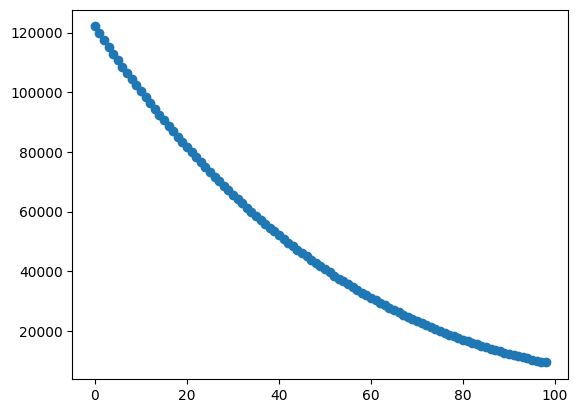

In [104]:
plt.plot(losses[1:],marker="o")

In [10]:
with torch.no_grad():
    sample_size = 100
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)

    # Without post-process
    gen_selfies = selfies.decode(x.round())
    print("# of generated data that match original data")
    print(df_smiles["selfies"].apply(lambda x: x in gen_selfies).sum())
    gen_smiles = [sf.decoder(s) for s in gen_selfies]


# of generated data that match original data
0


In [142]:
x

tensor([[ 5.4647,  8.6895,  7.6156,  ..., 20.4969, 20.4316, 20.4582],
        [ 4.4132,  7.3654,  6.6143,  ..., 17.6791, 17.6176, 17.6243],
        [ 5.1992,  7.6956,  6.9941,  ..., 18.5223, 18.5341, 18.5475],
        ...,
        [ 5.2954,  7.7220,  7.2053,  ..., 19.0224, 18.9986, 19.0057],
        [ 6.5435,  9.5818,  8.5665,  ..., 22.7244, 22.7448, 22.7793],
        [ 5.6896,  8.1909,  7.4413,  ..., 19.7852, 19.7841, 19.7826]])

In [143]:
x.round()

tensor([[ 5.,  9.,  8.,  ..., 20., 20., 20.],
        [ 4.,  7.,  7.,  ..., 18., 18., 18.],
        [ 5.,  8.,  7.,  ..., 19., 19., 19.],
        ...,
        [ 5.,  8.,  7.,  ..., 19., 19., 19.],
        [ 7., 10.,  9.,  ..., 23., 23., 23.],
        [ 6.,  8.,  7.,  ..., 20., 20., 20.]])

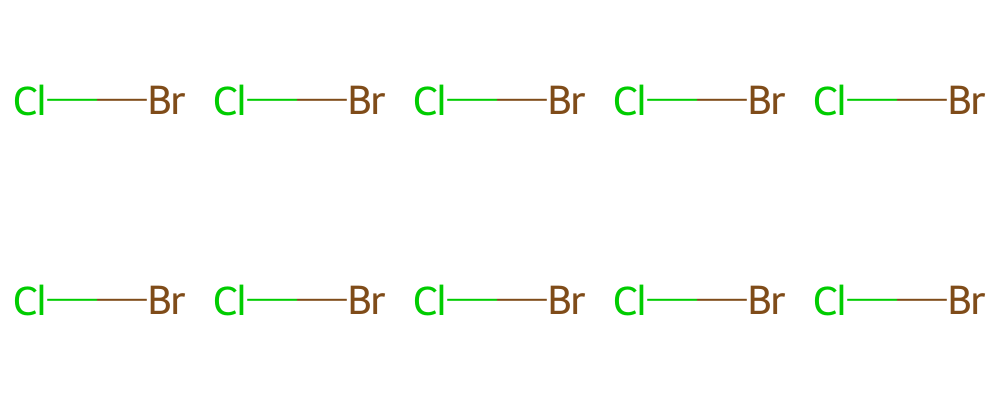

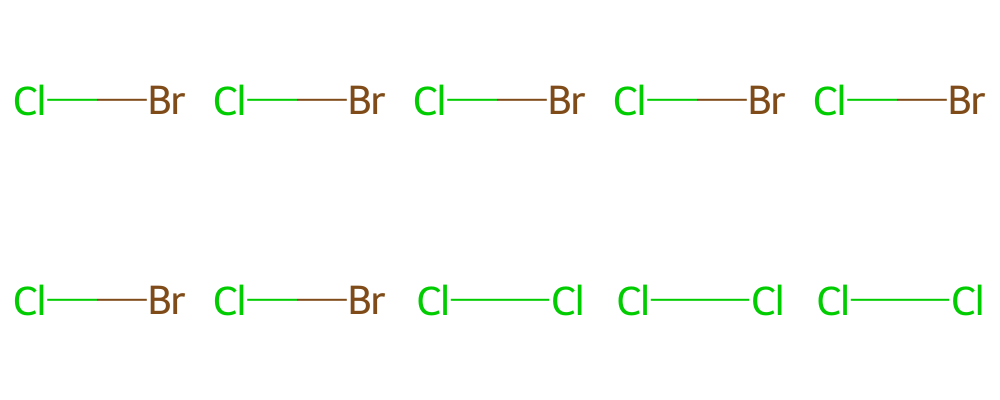

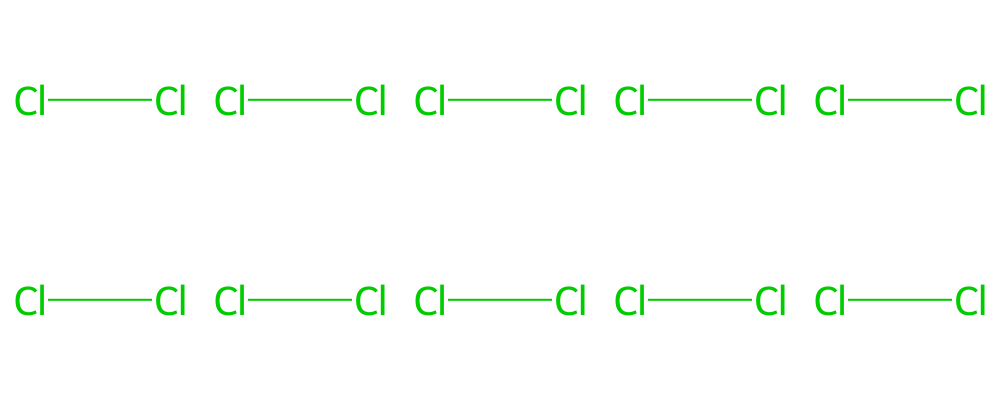

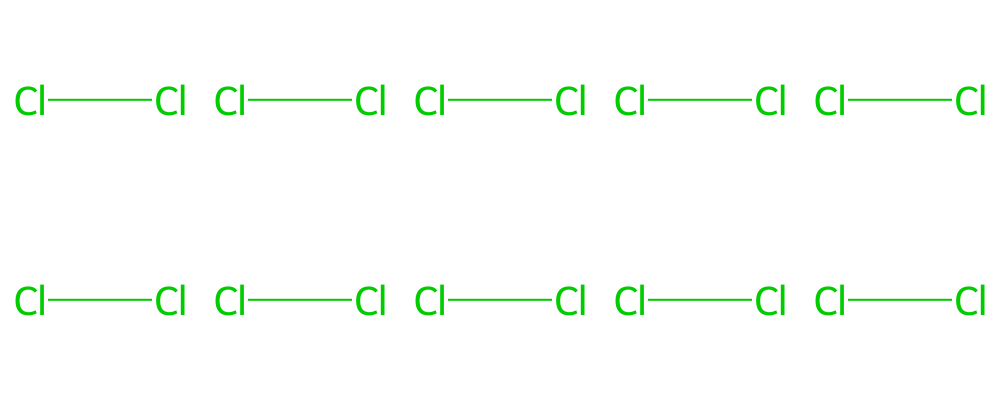

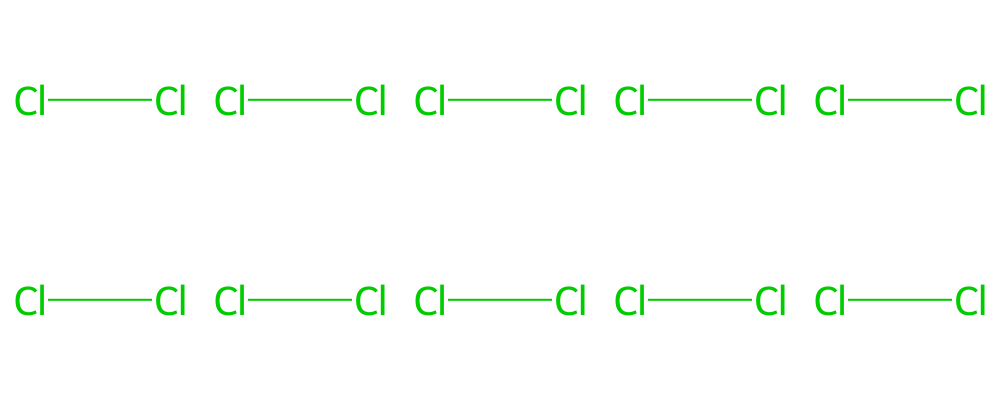

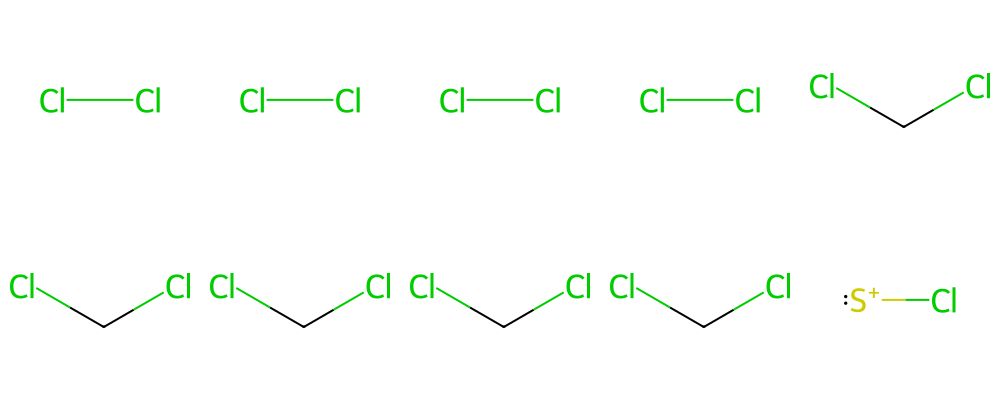

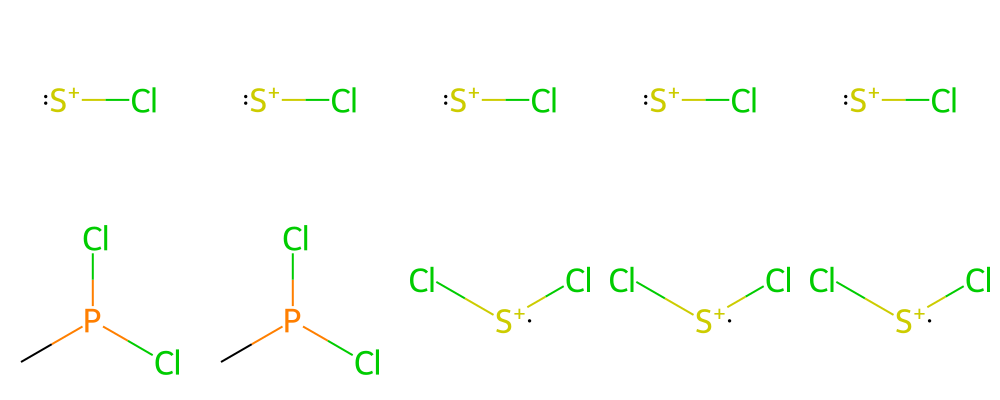

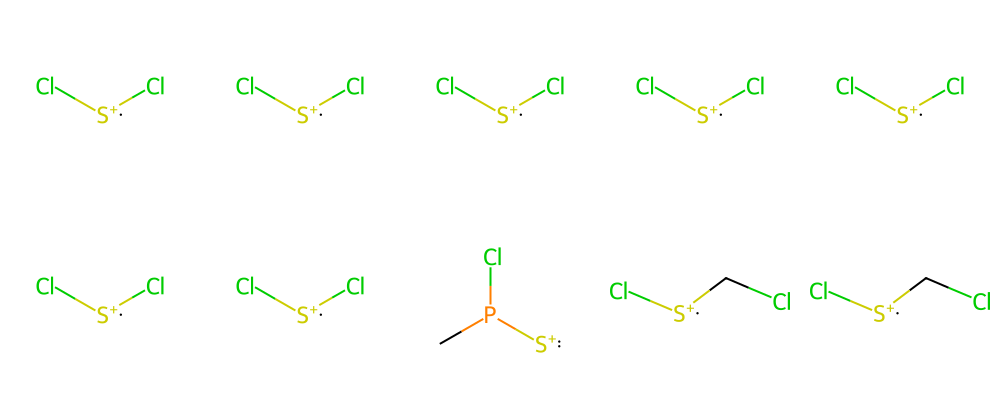

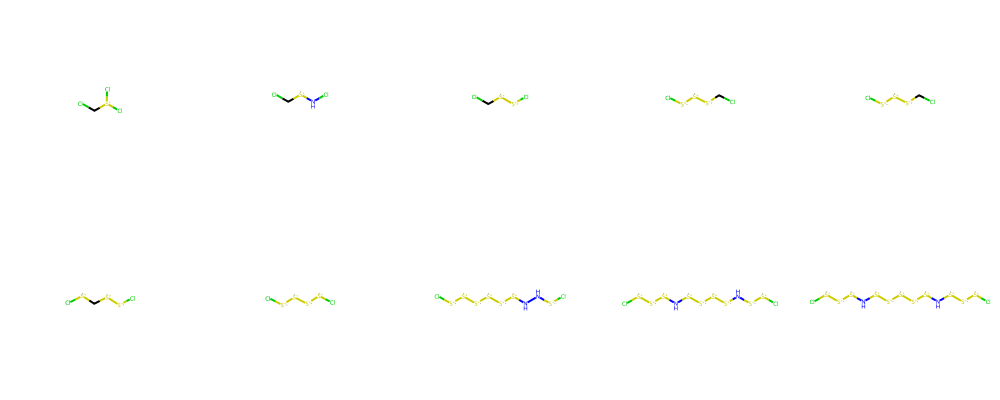

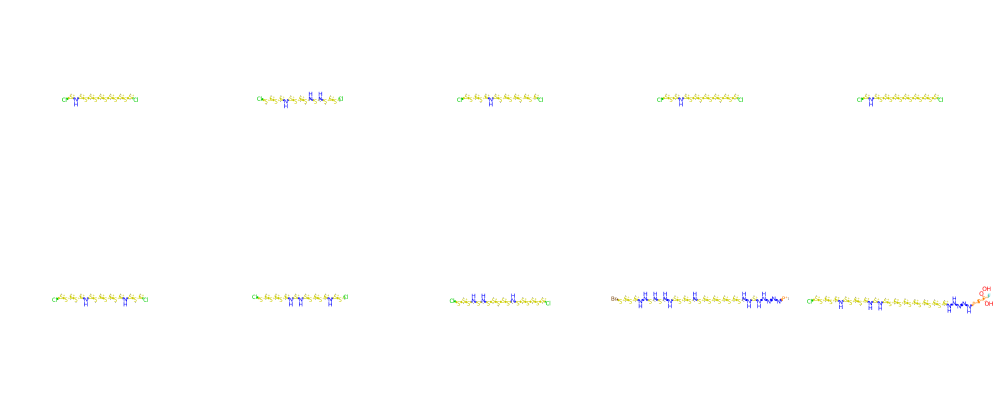

In [11]:
from rdkit.Chem import Draw
from rdkit import Chem
from IPython.display import display, SVG

gen_smiles_sorted = sorted_smiles = sorted(gen_smiles, key=lambda x: (len(x), x))
mols = [Chem.MolFromSmiles(s) for s in gen_smiles_sorted]
for i in range(10):
    img=Draw.MolsToGridImage(mols[i*10:(i+1)*10],molsPerRow=5,subImgSize=(200,200),useSVG=True)
    display(img)
    

In [129]:
idx = torch.randint(sample_size,(2,))
print(idx)
x.round()[idx,:]

tensor([11, 27])


tensor([[ 6.,  8.,  8.,  9.,  8.,  9.,  9.,  9.,  9.,  8.,  8.,  8.,  9., 10.,
          9.,  8.,  9.,  8.,  8.,  9.,  9.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,
          8.,  8.,  8.,  8.,  9.,  8.,  9.,  9.,  9., 10., 10., 10., 11., 11.,
         11., 12., 12., 12., 13., 13., 13., 14., 14., 14., 14., 14., 15., 15.,
         15., 15., 15., 15., 15., 15., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16.

In [52]:
selfies.index_to_token

{0: '[Ring1]',
 1: '[#Branch2]',
 2: '[=Ring2]',
 3: '[=O+1]',
 4: '[C]',
 5: '[=C]',
 6: '[#Branch1]',
 7: '[=N]',
 8: '[Ring2]',
 9: '[Branch1]',
 10: '[#N]',
 11: '[P]',
 12: '[N-1]',
 13: '[P+1]',
 14: '[#C]',
 15: '[^]',
 16: '[=Branch1]',
 17: '[=Ring1]',
 18: '[=O]',
 19: '[Branch2]',
 20: '[nop]',
 21: '[S]',
 22: '[Br]',
 23: '[S+1]',
 24: '[F]',
 25: '[N]',
 26: '[O]',
 27: '[=Branch2]',
 28: '[Cl]',
 29: '[NH1]'}